### A convolutional autoencoder, based on https://github.com/shibuiwilliam/Keras_Autoencoder/blob/master/Cifar_Conv_AutoEncoder.ipynb

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

In [2]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [3]:
import glob
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from matplotlib import colors, cm, pyplot as plt

In [4]:
RUN_NAME = '190719_Hela_Ecoli_1to1_01'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'
ENCODED_FEATURE_SLICES_DIR = '{}/encoded-features/{}/slices'.format(EXPERIMENT_DIR, RUN_NAME)
ENCODED_FEATURES_DIR = '{}/encoded-features/{}'.format(EXPERIMENT_DIR, RUN_NAME)

In [5]:
feature_slices_l = glob.glob("{}/feature-*-slice-*.png".format(ENCODED_FEATURE_SLICES_DIR))
image_arrays_l = []
for feature_slice in sorted(feature_slices_l):
    # load the image and generate the feature vector
    img = Image.open(feature_slice).resize((32,32))
    x = image.img_to_array(img)
    image_arrays_l.append(x)

In [6]:
image_arrays = np.array(image_arrays_l)

In [7]:
image_arrays.shape

(4985, 32, 32, 3)

In [8]:
image_arrays = image_arrays.astype('float32') / 255.

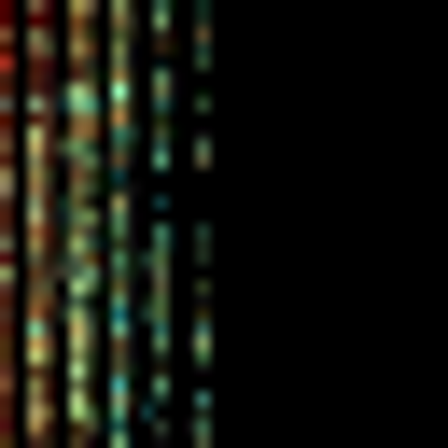

In [9]:
image.array_to_img(image_arrays[180]).resize((448,448))

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, _, _ = train_test_split(image_arrays, image_arrays, test_size=0.20)

In [11]:
X_train = np.reshape(X_train, (len(X_train), 32, 32, 3))
X_test = np.reshape(X_test, (len(X_test), 32, 32, 3))

In [12]:
# divide X_test into validation and test
split_num = int(len(X_test)/2)
X_val = X_test[:split_num]
X_test = X_test[split_num:]

In [13]:
X_train.shape, X_val.shape, X_test.shape

((3988, 32, 32, 3), (498, 32, 32, 3), (499, 32, 32, 3))

In [14]:
model = Model(inputs = input_img, outputs = decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128   

In [15]:
encoder = Model(inputs = input_img, outputs = encoded)

In [16]:
batch_size = 32
epochs = 100

In [21]:
logdir = "/tmp/tb/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [22]:
# train the model
history = model.fit(X_train, X_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, X_val),
                    callbacks=[tensorboard_callback],
                    shuffle=True)

Epoch 1/100
125/125 [==============================] - 16s 127ms/step - loss: 0.6958 - val_loss: 0.6372
Epoch 2/100
125/125 [==============================] - 16s 124ms/step - loss: 0.6211 - val_loss: 0.6003
Epoch 3/100
125/125 [==============================] - 16s 125ms/step - loss: 0.5646 - val_loss: 0.5386
Epoch 4/100
125/125 [==============================] - 16s 124ms/step - loss: 0.5162 - val_loss: 0.4913
Epoch 5/100
125/125 [==============================] - 16s 125ms/step - loss: 0.4734 - val_loss: 0.4514
Epoch 6/100
125/125 [==============================] - 16s 124ms/step - loss: 0.4343 - val_loss: 0.4129
Epoch 7/100
125/125 [==============================] - 16s 125ms/step - loss: 0.4003 - val_loss: 0.3864
Epoch 8/100
125/125 [==============================] - 16s 124ms/step - loss: 0.3679 - val_loss: 0.3536
Epoch 9/100
125/125 [==============================] - 16s 124ms/step - loss: 0.3402 - val_loss: 0.3274
Epoch 10/100
125/125 [==============================] - 16s 124m

In [23]:
encoded_imgs = encoder.predict(X_test)

In [24]:
decoded_imgs = model.predict(X_test)

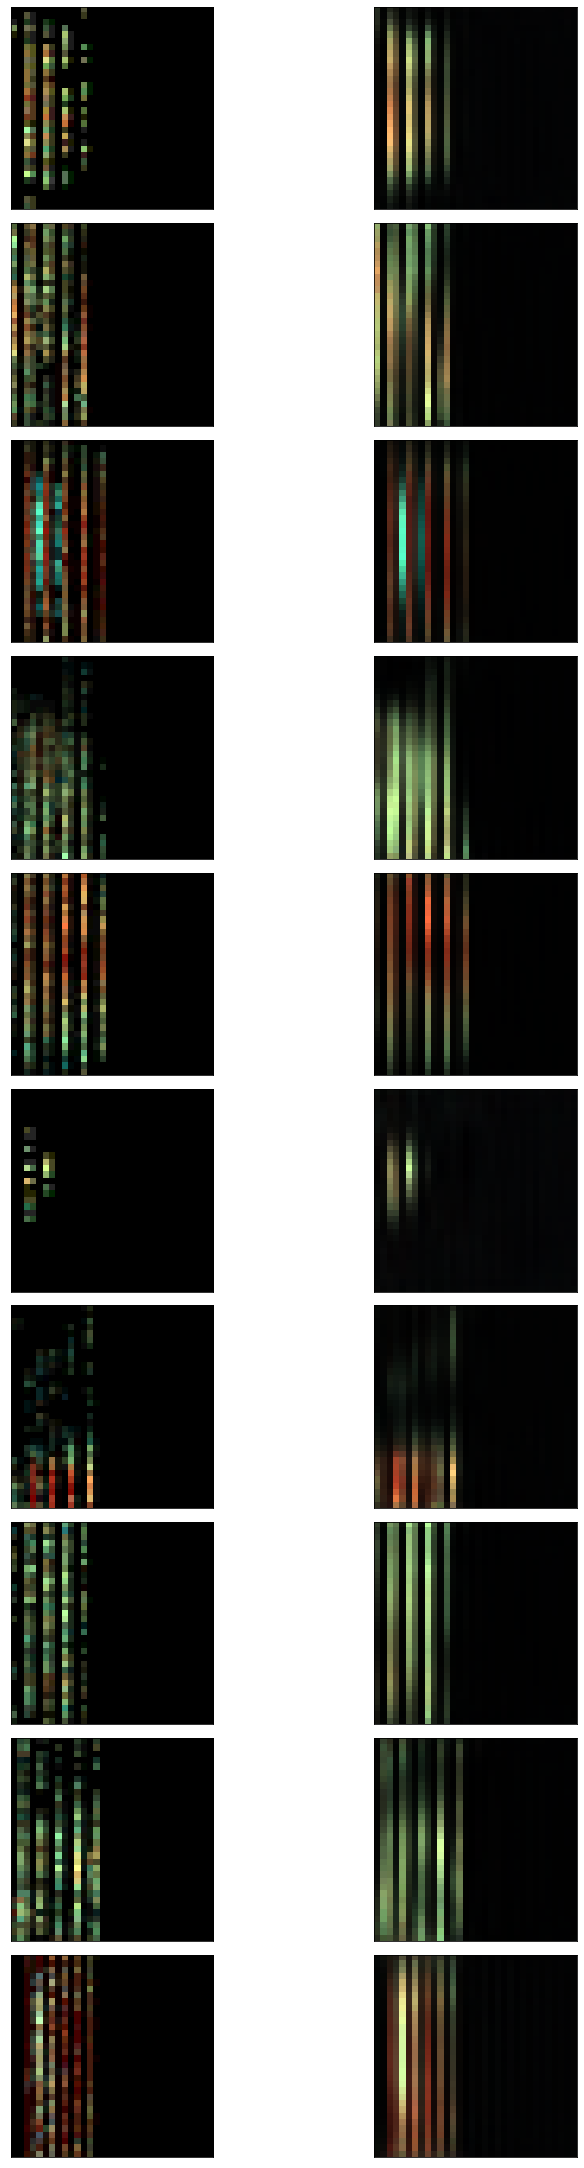

In [25]:
n = 10  # the number of images to display
columns = 2
rows = n

f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(30)
f.set_figwidth(10)

for i in range(n):
    # display original
    ax = axarr[i,0]  # row, column
    ax.imshow(image.array_to_img(X_test[i].reshape(32, 32, 3)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = axarr[i,1]  # row, column
    ax.imshow(image.array_to_img(decoded_imgs[i].reshape(32, 32, 3)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()